In [1]:
# Cell 1 - system

import sys
sys.path.append('src')

from __future__ import annotations
import torch

from typing import Callable

import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint
import torchaudio

import librosa

import os
import re
from importlib.resources import files
from pathlib import Path

import numpy as np
import soundfile as sf
import tomli
from cached_path import cached_path

import cyrtranslit


from f5_tts.infer.utils_infer import (
    infer_single_process,
    load_model,
    load_vocoder,
    preprocess_ref_audio_text,
    preprocess_ref_audio_text_segment,
    remove_silence_for_generated_wav,
)

from f5_tts.model.utils import (
    default,
    exists,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

from f5_tts.model import DiT, UNetT

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Image, Audio

# Direct variable assignments instead of command line arguments
model = "F5-TTS"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_40000.pt"
ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_last.pt"

# Default configurations
config_path = os.path.join(files("f5_tts").joinpath("infer/examples/basic"), "basic.toml")
config = tomli.load(open(config_path, "rb"))

# Additional settings with default values
vocab_file = ""
output_dir = config["output_dir"]
remove_silence = config.get("remove_silence", False)
speed = 1.0
vocoder_name = "vocos"
load_vocoder_from_local = False
wave_path = Path(output_dir) / "infer_cli_out.wav"

# Vocoder settings
if vocoder_name == "vocos":
    vocoder_local_path = "../checkpoints/vocos-mel-24khz"
elif vocoder_name == "bigvgan":
    vocoder_local_path = "../checkpoints/bigvgan_v2_24khz_100band_256x"
mel_spec_type = vocoder_name


vocoder = load_vocoder(vocoder_name=mel_spec_type, is_local=load_vocoder_from_local, local_path=vocoder_local_path)

# Model configuration
if model == "F5-TTS":
    model_cls = DiT
    model_cfg = dict(dim=1024, depth=22, heads=16, ff_mult=2, text_dim=512, conv_layers=4)
    # if not ckpt_file:
    #     if vocoder_name == "vocos":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base"
    #         ckpt_step = 1200000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.safetensors"))
    #     elif vocoder_name == "bigvgan":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base_bigvgan"
    #         ckpt_step = 1250000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.pt"))


ema_model = load_model(model_cls, model_cfg, ckpt_file, mel_spec_type=vocoder_name, vocab_file=vocab_file)

ckpt_file_fine = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"
ema_model_fine = load_model(model_cls, model_cfg, ckpt_file_fine, mel_spec_type=vocoder_name, vocab_file=vocab_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

2024-11-26 11:24:59,926 - INFO - PyTorch version 2.5.1+cu121 available.


Download Vocos from huggingface charactr/vocos-mel-24khz


/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_last.pt 


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt 



### Загрузка датасета

In [ ]:
# Cell 2, dataset loading

from russian_songs_dataset_utils import process_music_ref_dataset

base_ref_tracks = process_music_ref_dataset("/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb", cache_filename="ref_data_cache.json")
print(f"found {len(base_ref_tracks)} base tracks with lyrics")

Loading cached data from ref_data_cache.json
found 766 base tracks with lyrics


### Выбираем реф и задаём текстовый промпт

In [ ]:
# Cell 3, prompt selection

# # ref_audio = "src/f5_tts/infer/examples/basic/basic_ref_en.wav"
# # ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# # ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu. tem, kto druzhen, ne strashny trevogi. nam ljubye dorogi dorogi"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu."

def get_text_audio_and_end_time_path_for_ref(ref_id, section_num, base_ref_tracks):
    ref_track = base_ref_tracks[list(base_ref_tracks.keys())[ref_id]]
    words = ref_track['sections'][section_num]['words']
    mp3_path =ref_track['sections'][section_num]['mp3_path']
    return cyrtranslit.to_latin(words, "ru").lower(), mp3_path, ref_track['sections'][section_num]['end_time'], ref_track['mir_data']['bpm']

def to_translit(text):
    return cyrtranslit.to_latin(text, "ru").lower()

# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(80, 1, base_ref_tracks) # 80 плохой
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(105, 2, base_ref_tracks) # тут нужна скорость 0.1
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(500, 2, base_ref_tracks) # тут нужна скорость 0.3
ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(600, 0, base_ref_tracks) # монеточка,  скорость 0.3
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(630, 0, base_ref_tracks) # какой-то женский шансон,  скорость 0.3
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(638, 0, base_ref_tracks) #  скорость 0.6
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(640, 0, base_ref_tracks) # Этот всё выговаривает, скорость 0.5
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(645, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(648, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(680, 0, base_ref_tracks) # рэп, скорость 0.9
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(360, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(361, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(363, 0, base_ref_tracks) # ГЛЮК, тараторит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(366, 0, base_ref_tracks) # Очень глючно, рэп
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(367, 0, base_ref_tracks) # Какой-то глюк с длительностью, очень длинно генерит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(373, 0, base_ref_tracks) # Какой-то глюк с длительностью, очень длинно генерит
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(374, 0, base_ref_tracks) # Какой-то крутой вокалист, но звучит плохо
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(376, 0, base_ref_tracks) # 
# ref_text, ref_audio, ref_end_time, ref_bpm = get_text_audio_and_end_time_path_for_ref(377, 0, base_ref_tracks) # 

gen_text = to_translit("Эх, полным полна коробочка! Есть в ней ситец и парча. Пожалей, душа-зазнобушка молодецкого плеча")
# gen_text = to_translit("О-о-о-о, зеленоеглазое такси. О-о-о-о, притормози, притормози! О-о-о-о, ты отвези меня туда! О-о-о-о, где будут рады мне всегда! ")
# gen_text = to_translit("Ты сидишь на стуле с голым торсом, я смотрю на пиццу, у меня вопросы.")
# gen_text = to_translit("Эх, полным полна коробочка!")

In [12]:
zoom_start_in_seconds = 2.1  # Start of zoom window
zoom_end_in_seconds = 3.5    # End of zoom window

Converting audio...
Audio is over 15s, clipping short. (2)
Using cached reference text...


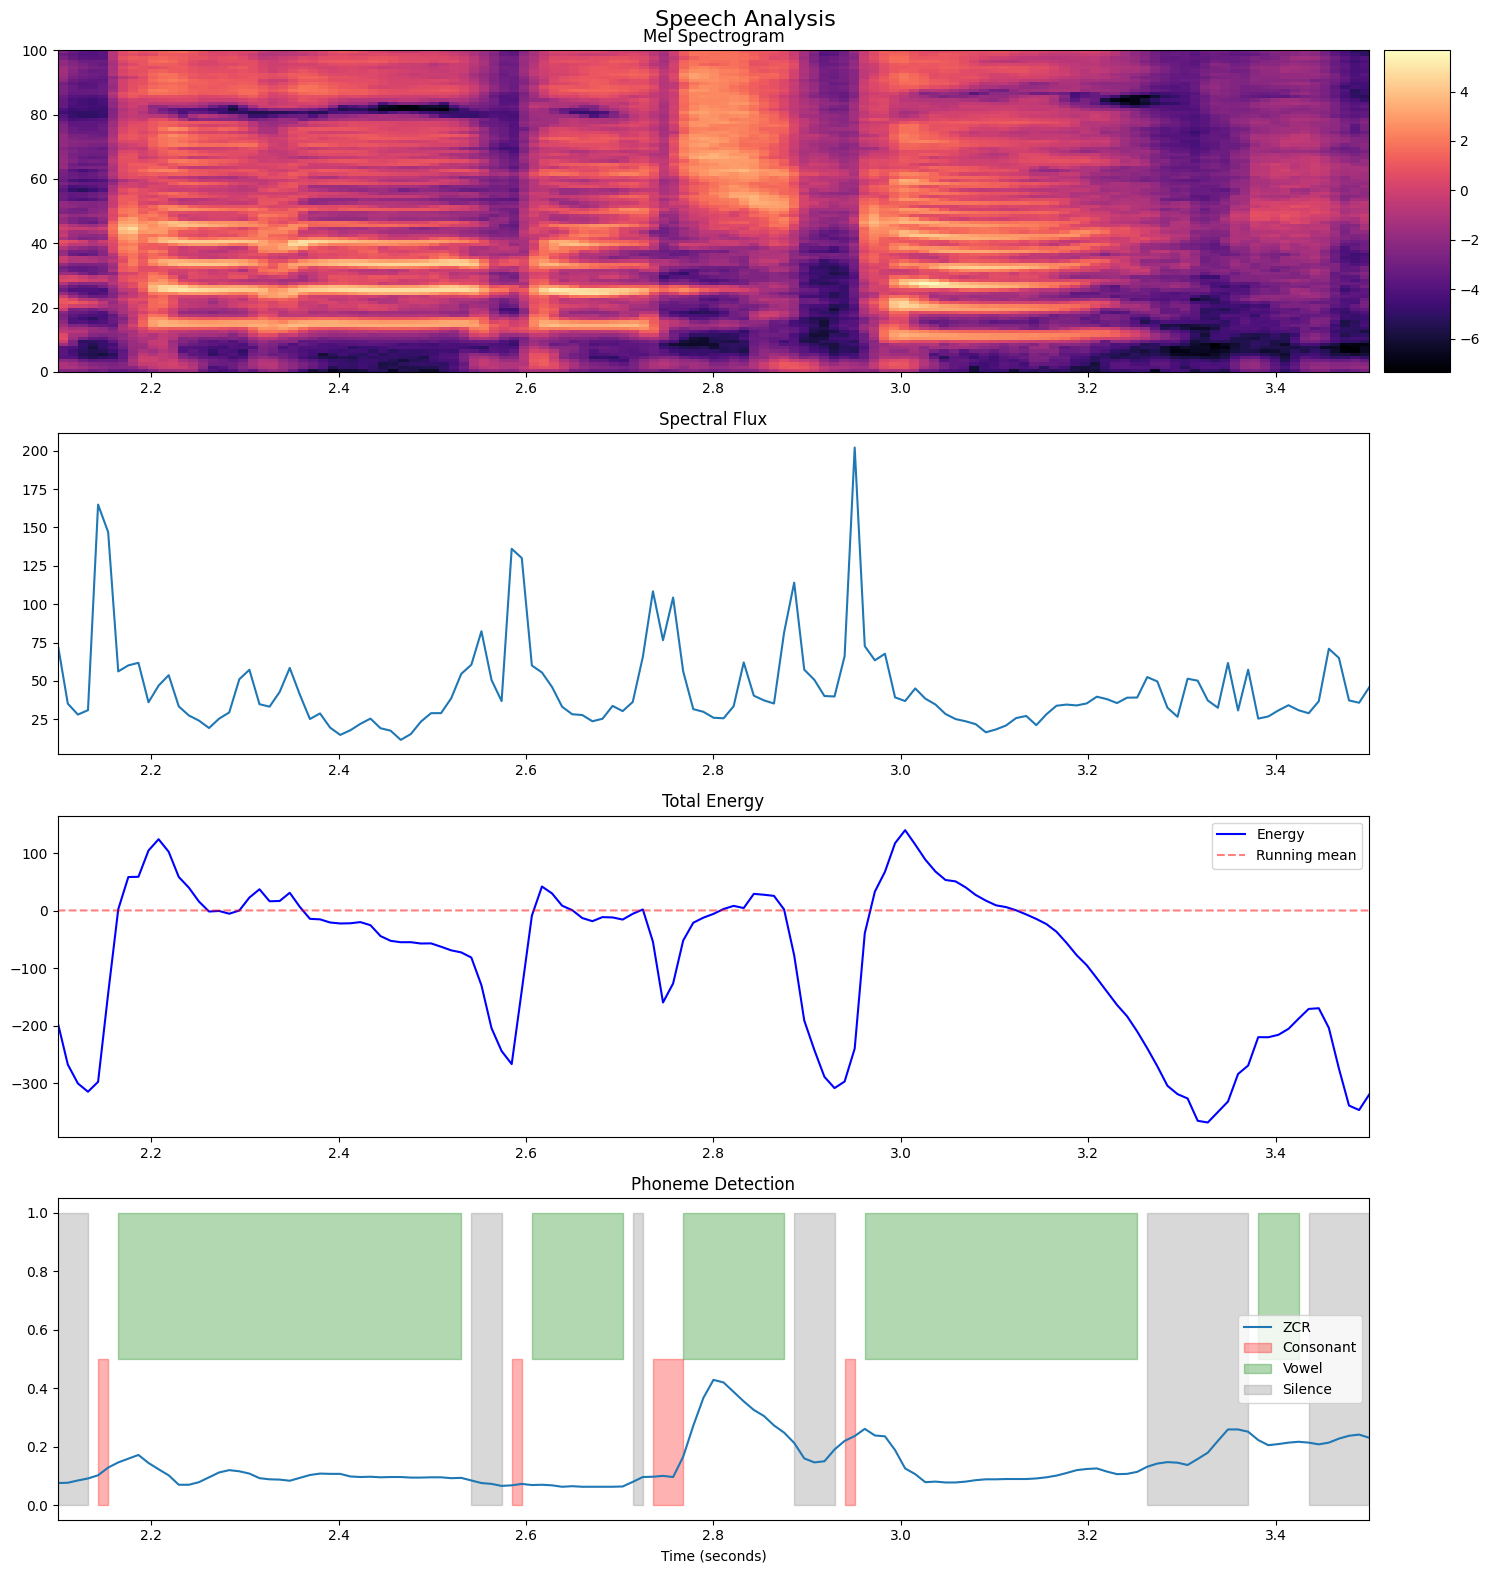

In [31]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.ndimage

def calculate_spectral_flux(mel_spec):
    diff = np.diff(mel_spec, axis=1)
    flux = np.sum(np.abs(diff), axis=0)
    return np.pad(flux, (0, 1), mode='edge')

def calculate_total_energy(mel_spec):
    return np.sum(mel_spec, axis=0)

def calculate_features(audio, sr, mel_spec):
    # Get the time axis length from mel spectrogram
    n_frames = mel_spec.shape[1]
    
    # Calculate required hop length to match mel spectrogram frames
    audio_length = len(audio)
    hop_length = int(audio_length / n_frames)
    frame_length = min(2048, hop_length * 4)  # Ensure frame length is reasonable
    
    # Calculate HNR
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
    hnr_values = []
    
    for frame in frames:
        if np.any(frame):
            acf = np.correlate(frame, frame, mode='full')[len(frame)-1:]
            peak_idx = np.argmax(acf[1:]) + 1
            peak_value = acf[peak_idx]
            
            noise_mask = np.ones_like(acf, dtype=bool)
            noise_mask[0] = False
            noise_mask[peak_idx] = False
            noise = np.mean(np.abs(acf[noise_mask]))
            
            if noise > 0:
                hnr = 20 * np.log10(peak_value / noise)
            else:
                hnr = 0
        else:
            hnr = 0
        hnr_values.append(hnr)
    
    # Calculate ZCR
    zcr = librosa.feature.zero_crossing_rate(
        audio, 
        frame_length=frame_length, 
        hop_length=hop_length
    )[0]
    
    # Ensure all features have exactly n_frames length
    hnr_values = np.array(hnr_values)[:n_frames]
    zcr = zcr[:n_frames]
    
    # Pad if necessary
    if len(hnr_values) < n_frames:
        hnr_values = np.pad(hnr_values, (0, n_frames - len(hnr_values)), mode='constant')
    if len(zcr) < n_frames:
        zcr = np.pad(zcr, (0, n_frames - len(zcr)), mode='constant')
    
    return hnr_values, zcr

# Previous feature calculation code remains the same until segmentation

def segment_phonemes(spectral_flux, energy, hnr, zcr):
    # Normalize all features to [0,1]
    flux_norm = (spectral_flux - np.min(spectral_flux)) / (np.max(spectral_flux) - np.min(spectral_flux) + 1e-10)
    energy_norm = (energy - np.min(energy)) / (np.max(energy) - np.min(energy) + 1e-10)
    hnr_norm = (hnr - np.min(hnr)) / (np.max(hnr) - np.min(hnr) + 1e-10)
    zcr_norm = (zcr - np.min(zcr)) / (np.max(zcr) - np.min(zcr) + 1e-10)
    
    # Calculate running statistics for both systems
    # System 1 - Consonant detection
    window_size_1 = 10
    running_mean_1 = np.convolve(energy_norm, np.ones(window_size_1)/window_size_1, mode='same')
    
    # System 2 - Vowel detection
    window_size_2 = 50
    running_mean_2 = np.convolve(energy_norm, np.ones(window_size_2)/window_size_2, mode='same')
    running_std_2 = np.array([np.std(energy_norm[max(0, i-window_size_2//2):min(len(energy_norm), i+window_size_2//2)]) 
                           for i in range(len(energy_norm))])
    
    # Initialize detection arrays
    consonants = np.zeros_like(energy_norm)
    vowels = np.zeros_like(energy_norm)
    
    # System 1: Consonant detection
    in_consonant = False
    consonant_start = 0
    min_consonant_duration = int(0.03 * frames_per_second)  # 10ms in frames
    
    for i in range(len(consonants)):
        if not in_consonant:
            if (energy_norm[i] <= running_mean_1[i] and 
                flux_norm[i] * (np.max(spectral_flux) - np.min(spectral_flux)) >= 50):
                in_consonant = True
                consonant_start = i
                consonants[i] = 1
        else:
            if (energy_norm[i] > running_mean_1[i] or 
                flux_norm[i] * (np.max(spectral_flux) - np.min(spectral_flux)) < 50):
                in_consonant = False
                # Check duration
                if i - consonant_start < min_consonant_duration:
                    consonants[consonant_start:i] = 0
            else:
                consonants[i] = 1
    
    # System 2: Vowel detection
    energy_threshold = running_mean_2 - running_std_2 * 0.5
    active_speech = energy_norm > energy_threshold
    
    # Find spectral flux peaks for extra consonant detection
    flux_peaks = scipy.signal.find_peaks(flux_norm, height=0.3, distance=10)[0]
    
    # Mark vowels in active speech regions
    for i in range(len(vowels)):
        if active_speech[i]:
            is_consonant = ((flux_norm[i] > 0.4) or 
                          (zcr_norm[i] > 0.6 and hnr_norm[i] < 0.4))
            if not is_consonant:
                vowels[i] = 1
    
    # Add vowels at flux peaks
    for peak in flux_peaks:
        if active_speech[peak]:
            window_radius = 2
            start_idx = max(0, peak - window_radius)
            end_idx = min(len(vowels), peak + window_radius + 1)
            vowels[start_idx:end_idx] = 0  # Remove vowels around flux peaks
    
    # Smooth vowel detection
    vowels = scipy.ndimage.median_filter(vowels, size=3)
    
    return consonants, vowels, running_mean_1, running_mean_2

# Generate audio and mel spectrogram
ref_audio_preprocessed, ref_text_preprocessed = preprocess_ref_audio_text(ref_audio, ref_text) 

first_audio, sr, mel_spec, first_trajectory = infer_single_process(
    ref_audio_preprocessed, ref_text_preprocessed, gen_text, ema_model, vocoder, 
    nfe_step=32,
    speed=1.0,
    end_step=32,
    seed=1234,
    cfg_strength=2.0,
)

# Calculate all features with aligned time axes
spectral_flux = calculate_spectral_flux(mel_spec)
total_energy = calculate_total_energy(mel_spec)
hnr, zcr = calculate_features(first_audio, sr, mel_spec)

# Perform segmentation
consonants, vowels, running_mean_1, running_mean_2 = segment_phonemes(spectral_flux, total_energy, hnr, zcr)

# Create time axis in seconds
time_axis = np.linspace(0, len(first_audio)/sr, mel_spec.shape[1])

# Trim audio according to zoom
zoom_samples_start = int(zoom_start_in_seconds * sr)
zoom_samples_end = int(zoom_end_in_seconds * sr)
zoomed_audio = first_audio[zoom_samples_start:zoom_samples_end]

# Find the corresponding frame indices for the mel spectrogram and features
frames_per_second = mel_spec.shape[1] / (len(first_audio) / sr)
frame_start = int(zoom_start_in_seconds * frames_per_second)
frame_end = int(zoom_end_in_seconds * frames_per_second)

# Trim all features
mel_spec_zoomed = mel_spec[:, frame_start:frame_end]
spectral_flux_zoomed = spectral_flux[frame_start:frame_end]
total_energy_zoomed = total_energy[frame_start:frame_end]
hnr_zoomed = hnr[frame_start:frame_end]
zcr_zoomed = zcr[frame_start:frame_end]
# Zoom the detections
consonants_zoomed = consonants[frame_start:frame_end]
vowels_zoomed = vowels[frame_start:frame_end]
running_mean_1_zoomed = running_mean_1[frame_start:frame_end]
running_mean_2_zoomed = running_mean_2[frame_start:frame_end]

# Create time axis for zoomed section
time_axis_zoomed = np.linspace(zoom_start_in_seconds, zoom_end_in_seconds, len(spectral_flux_zoomed))

# Create visualization with GridSpec
fig = plt.figure(figsize=(15, 16))  # Reduced height since we removed one panel
gs = plt.GridSpec(4, 2, width_ratios=[20, 1], figure=fig)
fig.suptitle('Speech Analysis', fontsize=16)

# 1. Mel Spectrogram
ax0 = fig.add_subplot(gs[0, 0])
im = ax0.imshow(mel_spec_zoomed, aspect='auto', origin='lower', cmap='magma',
                extent=[time_axis_zoomed[0], time_axis_zoomed[-1], 0, mel_spec_zoomed.shape[0]])
ax0.set_title('Mel Spectrogram')
cax = fig.add_subplot(gs[0, 1])
plt.colorbar(im, cax=cax)

# 2. Spectral Flux
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(time_axis_zoomed, spectral_flux_zoomed)
ax1.set_title('Spectral Flux')
fig.add_subplot(gs[1, 1]).set_visible(False)

# 3. Total Energy
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(time_axis_zoomed, total_energy_zoomed, 'b-', label='Energy')
ax2.plot(time_axis_zoomed, running_mean_zoomed, 'r--', alpha=0.5, label='Running mean')
ax2.legend()
ax2.set_title('Total Energy')
fig.add_subplot(gs[2, 1]).set_visible(False)

# 4. Zero-Crossing Rate and Segmentation
ax3 = fig.add_subplot(gs[3, 0])
# In the plot section, modify the last subplot:
ax3.plot(time_axis_zoomed, zcr_zoomed, label='ZCR')
ax3.set_title('Phoneme Detection')

# Add phoneme detections as background colors
ax3.fill_between(time_axis_zoomed, 0, 0.5, where=consonants_zoomed == 1, 
                color='red', alpha=0.3, label='Consonant')
ax3.fill_between(time_axis_zoomed, 0.5, 1, where=vowels_zoomed == 1,
                color='green', alpha=0.3, label='Vowel')
ax3.fill_between(time_axis_zoomed, 0, 1, where=(consonants_zoomed == 0) & (vowels_zoomed == 0),
                color='gray', alpha=0.3, label='Silence')
ax3.legend()

# Add empty axes for alignment
fig.add_subplot(gs[3, 1]).set_visible(False)

# Share x-axis
for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlim(time_axis_zoomed[0], time_axis_zoomed[-1])
    
# Set common x-label
ax3.set_xlabel('Time (seconds)')

# Adjust layout
plt.tight_layout()
plt.show()

# Save and play zoomed audio
sf.write("phoneme_test_nostretch.mp3", zoomed_audio, sr)
display(Audio("phoneme_test_nostretch.mp3"))